In [1]:
import pandas as pd
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
import os.path as osp

import torch
from torch_geometric.data import Data, Dataset
import torch_geometric
import torch_geometric.transforms as T

In [52]:
df_all = pd.read_csv('/home/dolo/dev/lmtd-simulator/data/raw/data_air.csv')  
df = df_all[df_all['Block Name']=='internalMesh']
df.head()

,Block Name,Point ID,Points_0,Points_1,Points_2,Points_Magnitude,T,U_0,U_1,U_2,U_Magnitude,alphat,epsilon,k,nut,p,p_rgh,rho
0,internalMesh,0,-0.01790,-0.1,-0.1,0.142550,298.15,0.0,0.1375,0.0,0.1375,0.052486,1.25853,0.099636,0.04502,100001.0,100000.0,1.16583
1,internalMesh,1,-0.01432,-0.1,-0.1,0.142145,298.15,0.0,0.1375,0.0,0.1375,0.052486,1.25853,0.099636,0.04502,100001.0,100000.0,1.16583
2,internalMesh,2,-0.01074,-0.1,-0.1,0.141829,298.15,0.0,0.1375,0.0,0.1375,0.052486,1.25853,0.099636,0.04502,100001.0,100000.0,1.16583
3,internalMesh,3,-0.00716,-0.1,-0.1,0.141602,298.15,0.0,0.1375,0.0,0.1375,0.052486,1.25853,0.099636,0.04502,100001.0,100000.0,1.16583
4,internalMesh,4,-0.00358,-0.1,-0.1,0.141467,298.15,0.0,0.1375,0.0,0.1375,0.052486,1.25853,0.099636,0.04502,100001.0,100000.0,1.16583


In [53]:
z_tube_start = -0.05
#df_1 = df[df['Points_2']<z_tube_start]
#mask = df['Points_2']>=z_tube_start
df.loc[:,'initial_T'] = 298 #df['T']
#df.loc[mask, "initial_T"] = 0
df.head()

/tmp/ipykernel_1625385/1328322884.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'initial_T'] = 298 #df['T']


,Block Name,Point ID,Points_0,Points_1,Points_2,Points_Magnitude,T,U_0,U_1,U_2,U_Magnitude,alphat,epsilon,k,nut,p,p_rgh,rho,initial_T
0,internalMesh,0,-0.01790,-0.1,-0.1,0.142550,298.15,0.0,0.1375,0.0,0.1375,0.052486,1.25853,0.099636,0.04502,100001.0,100000.0,1.16583,298
1,internalMesh,1,-0.01432,-0.1,-0.1,0.142145,298.15,0.0,0.1375,0.0,0.1375,0.052486,1.25853,0.099636,0.04502,100001.0,100000.0,1.16583,298
2,internalMesh,2,-0.01074,-0.1,-0.1,0.141829,298.15,0.0,0.1375,0.0,0.1375,0.052486,1.25853,0.099636,0.04502,100001.0,100000.0,1.16583,298
3,internalMesh,3,-0.00716,-0.1,-0.1,0.141602,298.15,0.0,0.1375,0.0,0.1375,0.052486,1.25853,0.099636,0.04502,100001.0,100000.0,1.16583,298
4,internalMesh,4,-0.00358,-0.1,-0.1,0.141467,298.15,0.0,0.1375,0.0,0.1375,0.052486,1.25853,0.099636,0.04502,100001.0,100000.0,1.16583,298


In [6]:
distance_between_cells_1 = np.sqrt((-0.01790--0.01432)**2)
distance_between_cells_2 = np.sqrt((-0.0925--0.1000)**2)
print(distance_between_cells_1,distance_between_cells_2)

0.00358 0.007500000000000007


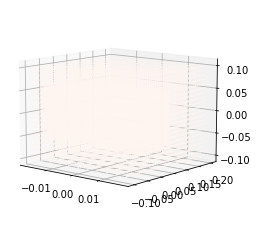

In [54]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.view_init(elev=10., azim=-50)
ax.scatter3D(df['Points_0'], df['Points_1'], df['Points_2'],c=df['initial_T'], s = 1,cmap='Reds');
#ax.scatter3D(df['Points_0'][0:20], df['Points_1'][0:20], df['Points_2'][0:20], c=df['initial_T'][0:20], s = 10);
#ax.scatter3D(df['Points_0'][0], df['Points_1'][0], df['Points_2'][0], c=df['Points_2'][0], s = 50);
#ax.scatter3D(df['Points_0'][1], df['Points_1'][1], df['Points_2'][1], c=df['Points_2'][1], s = 50);
#ax.scatter3D(df['Points_0'][11], df['Points_1'][11], df['Points_2'][11], c=df['Points_2'][11], s = 50);

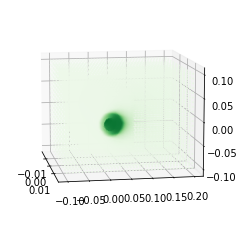

In [57]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.view_init(elev=10., azim=-10)
ax.scatter3D(df['Points_0'], df['Points_1'], df['Points_2'],c=df['T'], s = 1,cmap='Greens');
#ax.scatter3D(df['Points_0'][0:20], df['Points_1'][0:20], df['Points_2'][0:20], c=df['initial_T'][0:20], s = 10);
#ax.scatter3D(df['Points_0'][0], df['Points_1'][0], df['Points_2'][0], c=df['Points_2'][0], s = 50);
#ax.scatter3D(df['Points_0'][1], df['Points_1'][1], df['Points_2'][1], c=df['Points_2'][1], s = 50);
#ax.scatter3D(df['Points_0'][11], df['Points_1'][11], df['Points_2'][11], c=df['Points_2'][11], s = 50);

In [48]:
import plotly.express as px
#fig = px.scatter_3d(df, x='Points_0', y='Points_1', z='Points_2')
#fig.show()

In [8]:
num_nodes = 20
x = torch.Tensor(df[['initial_T']][0:num_nodes].to_numpy())
y = torch.Tensor(df[['T']][0:num_nodes].to_numpy())
pos = torch.Tensor(df[['Points_0','Points_1','Points_2']][0:num_nodes].to_numpy())
adj_t = torch.zeros((2,num_nodes))
edge_index = adj_t.nonzero().t().contiguous()
data = Data(x=x,edge_index = edge_index, pos = pos, y = y)

In [9]:
import networkx as nx
#g = torch_geometric.utils.to_networkx(data)
#nx.draw(g)

In [10]:
rg = T.RadiusGraph(0.01)

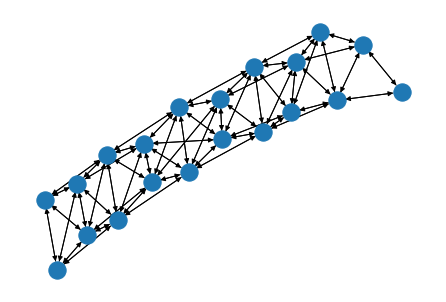

In [12]:
data_processed = rg(data)
g = torch_geometric.utils.to_networkx(data_processed)
nx.draw(g)

In [31]:
len(df)

190636

In [2]:
def read_cvs_and_change_to_graph(raw_path):
    df_all = pd.read_csv(raw_path) 
    df = df_all[df_all['Block Name']=='internalMesh']
    
    # add initial T
    #z_tube_start = -0.05
    #mask = df['Points_2']>=z_tube_start
    df.loc[:,'initial_T'] = 298.5
    #df.loc[mask, "initial_T"] = 0
    #convert to graph
    num_nodes = len(df)
    x = torch.Tensor(df[['initial_T','Points_0','Points_1','Points_2']][0:num_nodes].to_numpy())
    y = torch.Tensor(df[['T']][0:num_nodes].to_numpy())
    pos = torch.Tensor(df[['Points_0','Points_1','Points_2']][0:num_nodes].to_numpy())
    adj_t = torch.zeros((2,num_nodes))
    edge_index = adj_t.nonzero().t().contiguous()
    data = Data(x=x,edge_index = edge_index, pos = pos, y = y)
    return data

In [3]:
class CFD(Dataset):
    def __init__(self, root, transform=None, pre_transform=T.RadiusGraph(0.01), pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.root = root

    @property
    def raw_file_names(self):
        return ['data_air.csv']

    @property
    def processed_file_names(self):
        return ['not_implented.pt']

    def download(self):
        pass
    
    def process(self):
        idx = 0
        for raw_path in self.raw_paths:
            data = read_cvs_and_change_to_graph(raw_path) 
        
            if self.pre_filter is not None and not self.pre_filter(data):
                continue

            if self.pre_transform is not None:
                data = self.pre_transform(data)
            
            torch.save(data, osp.join(self.processed_dir, f'data_{idx}.pt'))
            idx += 1

    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        data = torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
        return data

In [4]:
dataset = CFD('/home/dolo/dev/lmtd-simulator/data/')
dataset.out_features = 1
data = dataset[0]

Processing...
/tmp/ipykernel_1637313/1744109155.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'initial_T'] = 298.5
Done!


In [12]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        """ GCNConv layers """
        self.conv1 = GCNConv(data.num_features, 512)
        self.conv2 = GCNConv(512, 512)
        self.conv3 = GCNConv(512, 512)
        self.conv4 = GCNConv(512, 512)
        self.conv5 = GCNConv(512, 512)
        self.conv6 = GCNConv(512, dataset.out_features)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.leaky_relu(x)
        x = self.conv2(x, edge_index)
        x = F.leaky_relu(x)
        x = self.conv3(x, edge_index)
        x = F.leaky_relu(x)
        x = self.conv4(x, edge_index)
        x = F.leaky_relu(x)
        x = self.conv5(x, edge_index)
        x = F.leaky_relu(x)
        x = self.conv6(x, edge_index)
        return x

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
model = GCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)#, weight_decay=5e-4)

In [15]:
# useful function for computing accuracy
import torch.nn as nn
loss_mse = nn.MSELoss()
def compute_mse(pred_y, y):
    return loss_mse(pred_y,y)

In [ ]:
# train the model
model.train()
losses = []
mses = []
for epoch in range(20):
    optimizer.zero_grad()
    out = model(data)
    loss = loss_mse(out, data.y)  #no train mask for now, the whole graph is used for training
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    if (epoch+1) % 1 == 0:
        print('Epoch: {}, Loss: {:.4f}'.format(epoch+1, loss.item()))


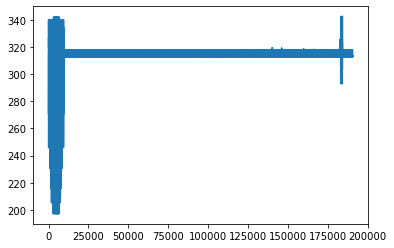

In [10]:
plt.plot(out.detach().numpy())

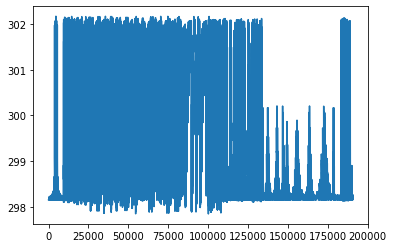

In [11]:
plt.plot(data.y.detach().numpy())